# Learning Scikit-learn: Machine Learning in Python

## IPython Notebook for Chapter 4: Advanced Features - Model Selection

_In the previous section we worked on ways to preprocess the data and select the most promising features. As we stated, selecting a good set of features is a crucial step to obtain good results. Now we will focus on another important step: selecting the algorithm parameters, known as hyperparameters to distinguish them from the parameters that are adjusted within the machine learning algorithm. Many machine learning algorithms include hyperparameters (from now on we will simply call them parameters) that guide certain aspects of the underlying method and have great impact on the results. In this section we will review some methods to help us obtain the best parameter configuration, a process known as model selection.
We will look back at the text-classification problem we addressed in Chapter 2, Supervised Learning. In that example, we compounded a TF-IDF vectorizer alongside a multinomial Naïve Bayes (NB) algorithm to classify a set of newsgroup messages into a discrete number of categories. The MultinomialNB algorithm has one important parameter, named alpha, that adjusts the smoothing. We initially used the class with its default parameter values (alpha = 1.0) and obtained an accuracy of 0.89. But when we set alpha to 0.01, we obtained a noticeable accuracy improvement to 0.92. Clearly, the configuration of the alpha parameter has great impact on the performance of the algorithm. How can we be sure 0.01 is the best value? Perhaps if we try other possible values, we could still obtain better results._

Start by importing numpy, scikit-learn, and pyplot, the Python libraries we will be using in this chapter. Show the versions we will be using (in case you have problems running the notebooks).

In [1]:
%pylab inline
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sk.__version__)
print ('matplotlib version:', matplotlib.__version__)


Populating the interactive namespace from numpy and matplotlib
IPython version: 6.1.0
numpy version: 1.13.1
scikit-learn version: 0.18.2
matplotlib version: 2.0.2


Let's start again with our text-classification problem, but for now we will only use a reduced number of instances. We will work only with 3,000 instances. 

In [2]:
from sklearn.datasets import fetch_20newsgroups

news = fetch_20newsgroups(subset='all')

n_samples = 3000

X = news.data[:n_samples]
y = news.target[:n_samples]

Then import the set of stop words and create a pipeline that compounds the TF-IDF vectorizer and the Naïve Bayes algorithms (recall that we had a stopwords_en.txt file with a list of stop words).

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
def get_stop_words():
    result = set()
    for line in open('data/stopwords_en.txt', 'r').readlines():
        result.add(line.strip())
    return result

stop_words = get_stop_words()
print(stop_words)

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('nb', MultinomialNB(alpha=0.01)),
])

{'thin', 'nothing', 'take', 'how', 'under', 'became', 'before', 'nor', 'then', 'any', 'latter', 'up', 'around', 'bill', 'ours', 'nevertheless', 'out', 'nowhere', 'eg', 'something', 'his', 'elsewhere', 'ourselves', 'be', 'herself', 'could', 'anyone', 'behind', 'sometimes', 'thereby', 'both', 'in', 'had', 'to', 'forty', 'has', 'however', 'often', 'although', 'due', 'off', 'anyway', 'very', 'alone', 'itself', 'less', 'seeming', 'down', 'he', 'keep', 'until', 'whether', 'beforehand', 'or', 'couldnt', 'please', 'someone', 'show', 'that', 'you', 'yourselves', 'as', 'fifteen', 'mine', 'must', 'rather', 'them', 'were', 'a', 'never', 'which', 'nine', 'hence', 'yourself', 'else', 'hereby', 'front', 'anywhere', 'four', 'per', 'serious', 'nobody', 'find', 'via', 'two', 'whereby', 'will', 'three', 'noone', 'we', 'your', 'therefore', 'everywhere', 'either', 'such', 'done', 'somehow', 'myself', 'go', 'other', 'they', 'him', 'throughout', 'sixty', 'always', 'below', 'next', 'yet', 'un', 'becoming', 'a

If we evaluate our algorithm with a three-fold cross-validation, we obtain a mean score of around 0.81.


In [5]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator of k=5 folds
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores)))

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
evaluate_cross_validation(clf, X, y, 3)

[ 0.812  0.808  0.822]
Mean score: 0.814 (+/-0.004)


It looks like we should train the algorithm with a list of different parameter values and keep the parameter value that achieves the best results. Let's implement a helper function to do that. This function will train the algorithm with a list of values, each time obtaining an accuracy score calculated by performing k-fold cross-validation
on the training instances. After that, it will plot the training and testing scores as a function of the parameter values.

In [7]:
def calc_params(X, y, clf, param_values, param_name, K):
    # initialize training and testing scores with zeros
    train_scores = np.zeros(len(param_values))
    test_scores = np.zeros(len(param_values))
    
    # iterate over the different parameter values
    for i, param_value in enumerate(param_values):
        print (param_name, ' = ', param_value)
        
        # set classifier parameters
        clf.set_params(**{param_name:param_value}) #rjm49 - double-splat convention converts dict to keyword args e.g. clf.set_params(param_name=param_value)
        
        # initialize the K scores obtained for each fold
        k_train_scores = np.zeros(K)
        k_test_scores = np.zeros(K)
        
        # create KFold cross validation
        cv = KFold(n_samples, K, shuffle=True, random_state=0)
        
        # iterate over the K folds
        for j, (train, test) in enumerate(cv):
            # fit the classifier in the corresponding fold
            # and obtain the corresponding accuracy scores on train and test sets
            clf.fit([X[k] for k in train], y[train])
            k_train_scores[j] = clf.score([X[k] for k in train], y[train])
            k_test_scores[j] = clf.score([X[k] for k in test], y[test])
            
        # store the mean of the K fold scores
        train_scores[i] = np.mean(k_train_scores)
        test_scores[i] = np.mean(k_test_scores)
       
    # plot the training and testing scores in a log scale
    plt.semilogx(param_values, train_scores, alpha=0.4, lw=2, c='b')
    plt.semilogx(param_values, test_scores, alpha=0.4, lw=2, c='g')
    
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

    # return the training and testing scores on each parameter value
    return train_scores, test_scores

Let's call this function; we will use numpy's logspace function to generate a list of alpha values spaced evenly on a log scale.

In [8]:
alphas = np.logspace(-7, 0, 8)
print (alphas)

[  1.00000000e-07   1.00000000e-06   1.00000000e-05   1.00000000e-04
   1.00000000e-03   1.00000000e-02   1.00000000e-01   1.00000000e+00]


nb__alpha  =  1e-07
nb__alpha  =  1e-06
nb__alpha  =  1e-05
nb__alpha  =  0.0001
nb__alpha  =  0.001
nb__alpha  =  0.01
nb__alpha  =  0.1
nb__alpha  =  1.0


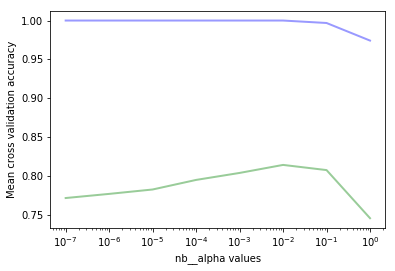

In [9]:
train_scores, test_scores = calc_params(X, y, clf, alphas, 'nb__alpha', 3)

As expected, the training accuracy is always greater than the testing accuracy. The best results are obtained with an alpha value of 0.1 (accuracy of 0.81):

In [10]:
print ('training scores: ', train_scores)
print ('testing scores: ', test_scores)

training scores:  [ 1.          1.          1.          1.          1.          1.
  0.99683333  0.97416667]
testing scores:  [ 0.77133333  0.77666667  0.78233333  0.79466667  0.80366667  0.814
  0.80733333  0.74533333]


We created a very useful function to graph and obtain the best parameter value for a classifier. Let's use it to adjust another classifier that uses a Support Vector Machines (SVM) instead of MultinomialNB:

In [11]:
from sklearn.svm import SVC

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('svc', SVC()),
])

svc__gamma  =  0.01
svc__gamma  =  0.1
svc__gamma  =  1.0
svc__gamma  =  10.0


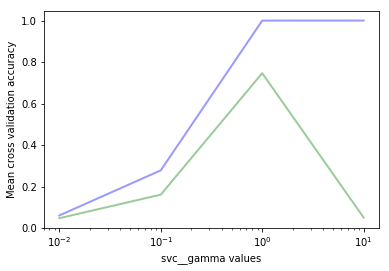

In [12]:
gammas = np.logspace(-2, 1, 4)

train_scores, test_scores = calc_params(X, y, clf, gammas, 'svc__gamma', 3)

In [14]:
print ('training scores: ', train_scores)
print ('testing scores: ', test_scores)

training scores:  [ 0.06183333  0.279       0.99966667  1.        ]
testing scores:  [ 0.04866667  0.162       0.74666667  0.05166667]


For gamma < 1 we have underfitting. For gamma > 1 we have overfitting. So here, the best result is for gamma = 1 where we obtain a training an accuracy of 0.999 and a testing accuracy of about 0.75

### Grid Search

If you take a closer look at the SVC class constructor parameters, we have other parameters, apart from gamma, that may also affect classifier performance. If we only adjust the gamma value, we implicitly state that the optimal C value is 1.0 (the default value that we did not explicitly set). Perhaps we could obtain better results with a new combination of C and gamma values. This opens a new degree of complexity; we should try all the parameter combinations and keep the better one.

With GridSearchCV, we can specify a grid of any number of parameters and parameter values to traverse. It will train the classifier for each combination and obtain a cross-validation accuracy to evaluate each one.


In [42]:
from sklearn.grid_search import GridSearchCV

parameters = {
    'svc__gamma': np.logspace(-2, 1, 4),
    'svc__C': np.logspace(-1, 1, 3),
}

clf = Pipeline([
    ('vect', TfidfVectorizer(
                stop_words=stop_words,
                token_pattern=r"\b[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+\b",         
    )),
    ('svc', SVC()),
])

gs = GridSearchCV(clf, parameters, verbose=2, refit=False, cv=3, n_jobs=-1)

Let's execute our grid search and print the best parameter values and scores.

In [43]:
%time _ = gs.fit(X, y)

gs.best_params_, gs.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Wall time: 2min 46s


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.8min finished


({'svc__C': 10.0, 'svc__gamma': 0.10000000000000001}, 0.8266666666666667)

With the grid search we obtained a better combination of C and gamma parameters, for values 10.0 and 0.10 respectively, we obtained a 3-fold cross validation accuracy of 0.828 much better than the best value we obtained (0.76) in the previous experiment by only adjusting gamma and keeeping C value at 1.0.

We could continue trying to improve the results by also adjusting the vectorizer parameters in the grid search.

# Parallelising

Grid search calculation grows exponentially with each parameter and its possible values we want to tune. We could reduce our response time if we calculate each of the combinations in parallel instead of sequentially, as we have done. In our previous example, we had four different values for gamma and three different values for C, summing up 12 parameter combinations. Additionally, we also needed to train each combination three times (in a three-fold cross-validation), so we summed up
36 trainings and evaluations. We could try to run these 36 tasks in parallel, since the tasks are independent.

Most modern computers have multiple cores that can be used to run tasks in parallel. We also have a very useful tool within IPython, a standalone module called ipyparallel (formerly IPython parallel), that allows us to run independent tasks in parallel, each task in a different core of our machine. Let's do that with our text classifier example.

First we will declare a function that will persist all the K folds for the cross validation in different files. These files will be loaded by a process that will execute the corresponding fold:

In [44]:
from sklearn.externals import joblib
from sklearn.cross_validation import ShuffleSplit
import os

def persist_cv_splits(X, y, K=3, name='data', suffix="_cv_%03d.pkl"):
    """Dump K folds to filesystem."""
    
    cv_split_filenames = []
    
    # create KFold cross validation
    cv = KFold(n_samples, K, shuffle=True, random_state=0)
    
    # iterate over the K folds
    for i, (train, test) in enumerate(cv):
        cv_fold = ([X[k] for k in train], y[train], [X[k] for k in test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

In [45]:
cv_filenames = persist_cv_splits(X, y, name='news')

The following function loads a particular fold and fits the classifier with the specified parameters set. Finally returns the testing score. This function will be called by each of the parallel processes:

In [46]:
def compute_evaluation(cv_split_filename, clf, params):
    
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib

    # load the fold training and testing partitions from the filesystem
    X_train, y_train, X_test, y_test = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    clf.set_params(**params)
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return test_score

This function executes the grid search in parallel processes. For each of the parameter combination (returned by the IterGrid iterator), it iterates over the K folds and creates a process to compute the evaluation. It returns the parameter combinations alongside with the tasks list: 

In [47]:
from sklearn.grid_search import ParameterGrid

def parallel_grid_search(lb_view, clf, cv_split_filenames, param_grid):
    
    all_tasks = []
    all_parameters = list(ParameterGrid(param_grid))
    
    # iterate over parameter combinations
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        # iterate over the K folds
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, clf, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

In [48]:
from sklearn.svm import SVC
from IPython.parallel import Client

client = Client()
lb_view = client.load_balanced_view()

all_parameters, all_tasks = parallel_grid_search(
   lb_view, clf, cv_filenames, parameters)

In [49]:
def print_progress(tasks):
    progress = np.mean([task.ready() for task_group in tasks
                                 for task in task_group])
    print ("Tasks completed: {0}%".format(100 * progress) )

In [50]:
print_progress(all_tasks)

Tasks completed: 0.0%


In [40]:
def find_bests(all_parameters, all_tasks, n_top=5):
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
                   
    return sorted(mean_scores, reverse=True)[:n_top]

In [41]:
print (find_bests(all_parameters, all_tasks))

[]
